In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import time
%matplotlib inline

import utils

In [2]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [3]:
print ("Started!!")

st = time.time()
start_date="2014-04-01"
end_date="2016-04-01"
input_data, input_list = utils.get_fixed_data(input_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
fail_name_list:  []


IndexError: list index out of range

In [ ]:
input_value = input_data.values
index = input_data.index
input_tilde = pd.DataFrame(input_value[:, :10], index=index)

In [ ]:
print (input_tilde.values.shape)

In [ ]:
print(input_data.index)

# DDPG for trading


Given data, you are going to learn how to manage your portfolio.

In [47]:
# import numpy as np 
# input_data = np.zeros((505, 99))
# n_stock = len(input_tilde.values[0])
n_stock = 10

class MultiDDPGConfig(object):
    activation = 'relu'
    gamma = 0.99
    history_length = 6
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 10
    n_feature = 5
    update_rate = 1e-1
    learning_rate = 1e-2

In [48]:
index = pd.date_range('23/10/2016', periods=100, freq='D')
value = np.random.normal(0, 1, (len(index), n_stock))
input_data = pd.DataFrame(value, index=index)

In [49]:
from collections import deque, namedtuple
import numpy as np

Experiecne = namedtuple('Experience', 'state0, reward, state1')

class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        # self.data = [None for _ in range(maxlen)]
        self.data = []
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx< 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]
    
    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item
            self.data[:-1] = self.data[1:]
        else:
            # This should never happen
            raise RuntimeError()
        self.data.append(v)
        
class SequentialMemory(object):
    def __init__(self, limit=1000):
        self.limit = limit
        
        self.rewards = RingBuffer(limit)
        self.observations = RingBuffer(limit)
        
    def sample(self, batch_size, window_length):
        # draw random indexes such that is bigger than window_length to enough length data
        batch_idx = np.random.random_integers(window_length, self.nb_entries - 1, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries - 1]))
        assert len(batch_idx) == batch_size
        
        # create experiences
        state0 = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        reward = np.array([self.rewards[idx - 1] for idx in batch_idx])
        state1 = np.array([[self.observations[i] for i in range(idx - window_length + 1,idx + 1)] for idx in batch_idx])
        return Experiecne(state0, reward, state1)
    
    def sample_state(self, batch_size, window_length):
        # draw random indexes such that is bigger than window_length to enough length data
        batch_idx = np.random.random_integers(window_length, self.nb_entries - 1, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries]))
        assert len(batch_idx) == batch_size
        
        # create experiences
        state = np.array([[self.observations[i] for i in range(idx - window_length, idx)] for idx in batch_idx])
        return state
    
    def append(self, observation, reward):
        self.observations.append(observation)
        self.rewards.append(reward)  
    
    @property
    def nb_entries(self):
        return  len(self.observations)

In [76]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda, Reshape
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import time

# from memory import SequentialMemory

class DQN(object):
    """Deep Deterministic Poilicy Gradient
    
    Basend on DPG and Multiscale CNN, seek out 
    optimal strategy for stock trading.
    
    Available function
    - build_model: build network basedon tensorflow and keras
    - train: given DateFrame stock data, train network
    """
    
    def __init__(self, config):
        """initialized approximate value function
        
        config should have the following attributes
        
        Args:
            gamma(float): the decay rate for value at RL
            history_length(int): input_length for each scale at CNN
            n_feature(int): the number of type of input 
                (e.g. the number of company to use at stock trading)
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): the nubmer of history that will be used as input
            n_smooth, n_down(int): the number of smoothed and down sampling input at CNN
            k_w(int): the size of filter at CNN
            n_hidden(int): the size of fully connected layer
            n_batch(int): the size of mini batch
            n_epochs(int): the training epoch for each time
            update_rate (0, 1): parameter for soft update
            learning_rate(float): learning rate for SGD
        """
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_feature = config.n_feature
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.update_rate = config.update_rate
        self.lr = config.learning_rate
        # the actual dimention of input
        self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length , (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            self.build_model()
        print('finished building model!')
    
    def train(self, input_data, noise_scale=2.0):
        """training DDPG, where action is confined to integer space
        
        Args:
            data (DataFrame): stock price for self.n_feature companies
        """
        stock_data = input_data.values
        date_data = input_data.index
        T = len(stock_data)
        
        # frequency for output
        print_freq = int(T / 100)
        if print_freq == 0:
            print_freq = 1
            
        print_freq = 1
            
        print ("training....")
        st = time.time()
        # the number of poassed stocks for each company
        # result for return value
        values = []
        dates = []
        for i in range(self.n_stock):
            values.append([])
            dates.append([])
        # keep half an year data 
        memory = SequentialMemory(360)
        for t in range(T):
            price = stock_data[t]
            reward = np.concatenate((np.reshape(stock_data[t], (self.n_stock, 1)), np.zeros((self.n_stock, 1))), axis=-1)
            memory.append(price, reward)
            # until having enough data, just do nothing
            if t <= self.n_history + self.n_batch:
                continue
            # to stabilize batch normalization, use other samples for prediction
            pred_state = memory.sample_state(self.n_batch, self.n_history)
            # update network
            action_value = self.sess.run(self.action,
                                      feed_dict={self.state: pred_state,
                                                K.learning_phase(): 0})[-1]
            # add return value when exit value is better
            for i in range(self.n_stock):
                if action_value[i] == 0:
                    values[i].append(price[i])
                    dates[i].append(date_data[t])
                    
            for epoch in range(self.n_epochs):    
                # select transition from pool
                experiences = memory.sample(self.n_batch, self.n_history)
                self.sess.run(self.critic_optim, 
                              feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.learning_rate: self.lr,
                                         K.learning_phase(): 1})  
                
                loss = self.sess.run(self.loss, feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         K.learning_phase(): 0})
                
                """
                target_value = self.sess.run(self.target_value, feed_dict={
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         self.portfolio_target: experiences.portfolio1,
                                         K.learning_phase(): 0})
                """
                # print('critic_value', critic_value)
                
                
                # print('target:', np.mean(target_value))
                # print('Q_value:', np.mean(target_value - experiences.reward))
                # print('reward:', np.mean(experiences.reward))
                    
                # softupdate for critic network
                old_weights = self.critic_target.get_weights()
                new_weights = self.critic.get_weights()
                weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w for new_w, old_w in zip(new_weights, old_weights)]
                self.critic_target.set_weights(weights)         
                 
            if t % print_freq == 0:
                print ("time:",  date_data[t])
                print('loss:', loss)
                print ("elapsed time", time.time() - st)    

        print ("finished training")
           
        return pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        input_q = [raw,] +  smoothed + down
        self.Q = self.critic(input_q)
        self.action = tf.argmax(self.Q, dimension=2)
        # target network
        input_q_target = [raw_target,] +  smoothed_target + down_target
        Q_target = self.critic_target(input_q_target)
        self.reward = tf.placeholder(tf.float32, [None, self.n_stock, 2], name='reward')
        Q_max =  tf.reshape(tf.reduce_max(Q_target, reduction_indices=[2]), [-1, self.n_stock, 1])
        Q_value = tf.concat(2, (tf.zeros_like(Q_max), Q_max))
        self.target = self.reward  + self.gamma * Q_value
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.loss = tf.reduce_mean(tf.square(self.target - self.Q), name='loss')
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # initialize network
        tf.initialize_all_variables().run(session=self.sess)
        weights = self.critic.get_weights()
        self.critic_target.set_weights(weights)
        
    def build_critic(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth)]
        for m in sm_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down)]
        for m in dw_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        nf = self.n_feature
        state.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
        # state.add(SpatialDropout2D(0.2))
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        model = Sequential()
        model.add(merged)
        # merged_state.add(SpatialDropout2D(0.2))
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(2 * self.n_stock))
        model.add(Reshape((self.n_stock, 2)))
        return model
    
    def transform_input(self, input):
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :] for st in range(n_sm)]),0)
            )
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down


# import numpy as np 
# input_data = np.zeros((505, 99))
n_stock = len(input_tilde.values[0])
# n_stock = 99

class MultiDDPGConfig(object):
    activation = 'relu'
    gamma = 0.99
    history_length = 10
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 100
    n_feature = 32
    update_rate = 1e-3
    learning_rate = 1e-3

In [77]:
# import numpy as np 
# input_data = np.zeros((505, 99))
# n_stock = len(input_tilde.values[0])
n_stock = 10

class MultiDDPGConfig(object):
    activation = 'relu'
    gamma = 0.99
    history_length = 6
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 10
    n_feature = 5
    update_rate = 1e-1
    learning_rate = 1e-2

In [ ]:
# from model import DDPG
import warnings
warnings.filterwarnings("ignore")

config = MultiDDPGConfig()

dqn = DQN(config)
print ("start!")
values = dqn.train(input_data)
print ("finished!")

building model....


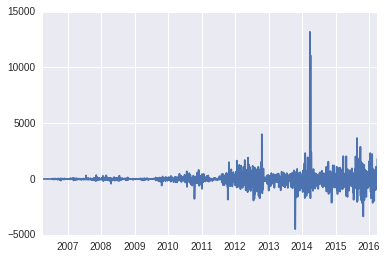

In [69]:
plt.plot(values)

In [53]:
date_label = input_data.index

In [60]:
date_label[0]

Timestamp('2015-04-01 00:00:00')

In [57]:
date_list = list(date_label)

In [59]:
pd.DatetimeIndex(date_list)

DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07',
               '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13',
               '2015-04-14', '2015-04-15',
               ...
               '2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01'],
              dtype='datetime64[ns]', length=253, freq=None)

In [8]:
values = [None] * 10
dates = [None]*10

In [10]:
values[i].append(1)

NameError: name 'i' is not defined

In [63]:
tf.zeros([2, 3, 4], tf.int32)

<tf.Tensor 'zeros_141:0' shape=(2, 3, 4) dtype=int32>